In [4]:
# Import internal libraries
import glob

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data"
for bpc in range(1, 3):
    for att in range(10, 250, 20):
        # Load and compute data
        postread = np.loadtxt(f"{datadir}/postread_{bpc}bpc_{att}.csv", delimiter=',', dtype=np.int8)
        dt = np.loadtxt(f"{datadir}/dt_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivdd_dac = np.loadtxt(f"{datadir}/vdd_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivsa = np.loadtxt(f"{datadir}/vsa_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        ivddio_dac = np.loadtxt(f"{datadir}/vddio_power_{bpc}bpc_{att}.csv", delimiter=',')
        power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
        energy_tot = power_tot * dt
        bw = 2**16 * 48 * bpc / dt # bits per second
        energy_per_bit = energy_tot / 2**16 / 48 / bpc
        edp = energy_per_bit / bw

        # Load data into confmat
        confmat = np.zeros(shape=(2**bpc, 2**bpc))
        for i in range(65536):
            for j in range(48):
                if j in [19,29,38,43]:
                    continue
                confmat[j % (2**bpc)][postread[i][j]] += 1
        confmat = confmat.astype(int)
        print(confmat)

        # Symbol error magnitudes
        mae = sum(abs(i - j) * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum()
        rmse = np.sqrt(sum((i - j)**2 * confmat[i][j] for i in range(2**bpc) for j in range(2**bpc)) / confmat.sum())

        # Function to get Gray code string
        getgray = lambda x : format(2**(2**bpc) + x^x//2, f"0{2**bpc-1}b")[1:]

        # Function to get Gray code error rate for each possible symbol confusion
        grayerr = np.array([[sum([int(ic != jc) for ic, jc in zip(getgray(i), getgray(j))]) for i in range(2**bpc)] for j in range(2**bpc)]) / bpc

        # BER and CER
        ber = (grayerr * confmat).sum() / confmat.sum()
        cer = confmat.trace() / confmat.sum()
        
        # Compose dataframe
        data.append({"att": att, "bpc": bpc, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": cer, "ber": ber, "mae": mae, "rmse": rmse})
data = pd.DataFrame(data)
data

[[749240    766   5880  30546]
 [250693 438641   8191  23371]
 [ 87247  24439 594688  14522]
 [     1      0     45 655314]]
[[760247    209   1803  24173]
 [148948 550271   4285  17392]
 [ 31463  19423 662250   7760]
 [     0      0     19 655341]]
[[764752    102    629  20949]
 [ 97740 605766   3327  14063]
 [ 18433  15258 681010   6195]
 [     0      0     20 655340]]
[[765750     63    457  20162]
 [ 77493 629134   2247  12022]
 [ 14876  14200 686127   5693]
 [     0      0     10 655350]]


,att,bpc,dt,power_tot,energy_per_bit,edp,bw,cer,ber,mae,rmse
0,10,2,0.4914827346801758,0.034320,2.681020e-09,2.094388e-16,1.280097e+07,0.062831,0.097483,0.216152,0.600428
1,30,2,0.9021015167236328,0.033392,4.787882e-09,6.865112e-16,6.974222e+06,0.062831,0.053082,0.122930,0.456468
2,50,2,1.1292006969451904,0.033534,6.018800e-09,1.080264e-15,5.571601e+06,0.062831,0.036385,0.087301,0.392256
3,70,2,1.3448421955108643,0.033420,7.143677e-09,1.527010e-15,4.678211e+06,0.062831,0.030271,0.074526,0.368037


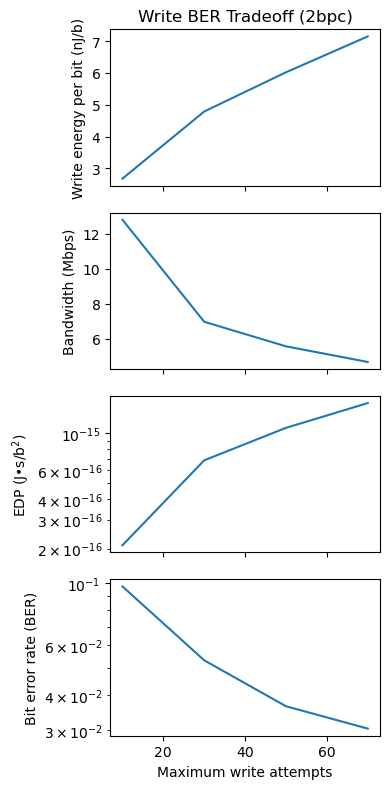

In [16]:
# Plot write BER tradeoff vs. attempts
for bpc, d in data.groupby("bpc"):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    axs[0].set_title(f"Write BER Tradeoff ({bpc}bpc)")
    axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
    axs[0].set_ylabel("Write energy per bit (nJ/b)")
    axs[1].plot(d["att"], d["bw"]/1e6)
    # axs[1].set_yscale("log")
    axs[1].set_ylabel("Bandwidth (Mbps)")
    axs[2].plot(d["att"], d["edp"])
    axs[2].set_yscale("log")
    axs[2].set_ylabel("EDP (J•s/b$^2$)")
    axs[3].plot(d["att"], d["ber"])
    axs[3].set_yscale("log")
    axs[3].set_ylabel("Bit error rate (BER)")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_write_ber_tradeoff.pdf")
    plt.show()

## Experiments part

In [ ]:
# Analyze reliability, bandwidth, energy
data = []
datadir = "data/"
for fname in glob.glob(f"{datadir}/dt_*.csv"):
    # Extract info from filename
    _, _, bpc, lvl, expt, att = fname[:-4].split('_')[-6:]
    bpc, lvl, expt, att = int(bpc[0]), int(lvl[3:]), int(expt), int(att)

    # Load and compute data
    try:
        postread = np.loadtxt(fname.replace("dt", "postread"), delimiter=',', dtype=np.int8)
        dt = np.loadtxt(fname, delimiter=',')
        ivdd = np.loadtxt(fname.replace("dt", "vdd_power"), delimiter=',')
        ivdd_dac = np.loadtxt(fname.replace("dt", "vdd_dac_power"), delimiter=',')
        ivsa = np.loadtxt(fname.replace("dt", "vsa_power"), delimiter=',')
        ivddio = np.loadtxt(fname.replace("dt", "vddio_power"), delimiter=',')
        ivddio_dac = np.loadtxt(fname.replace("dt", "vddio_dac_power"), delimiter=',')
    except OSError:
        continue
    postread_cer = (postread != lvl).mean()
    power_tot = ivdd * 0.9 + ivdd_dac * 0.9 + ivsa * 0.9 + ivddio_dac * 3.3 + ivddio * 3.3
    energy_tot = power_tot * dt
    bw = 2**16 * 48 * bpc / dt # bits per second
    energy_per_bit = energy_tot / 2**16 / 48 / bpc
    edp = energy_per_bit / bw

    # Confusion vector
    confvec = np.unique(postread, return_counts=True)
    print(confvec)

    # Compose dataframe
    data.append({"att": att, "bpc": bpc, "lvl": lvl, "expt": expt, "dt": dt, "power_tot": power_tot, "energy_per_bit": energy_per_bit, "edp": edp, "bw": bw, "cer": postread_cer})
data = pd.DataFrame(data)
data

In [ ]:
# Plot write BER tradeoff vs. attempts
for (bpc, lvl), d2 in data.groupby(["bpc", "lvl"]):
    fig, axs = plt.subplots(4, 1, figsize=(4,8), sharex=True)
    plt.xlabel("Maximum write attempts")
    for expt, d in d2.sort_values("att").groupby("expt"):
        axs[0].set_title(f"Write Error Tradeoff ({bpc}bpc, range {lvl})")
        axs[0].plot(d["att"], d["energy_per_bit"]*1e9)
        axs[0].set_yscale("log")
        axs[0].set_ylabel("Write energy per bit (nJ/b)")
        axs[1].plot(d["att"], d["bw"]/1e6)
        # axs[1].set_yscale("log")
        axs[1].set_ylabel("Bandwidth (Mbps)")
        axs[2].plot(d["att"], d["edp"])
        axs[2].set_yscale("log")
        axs[2].set_ylabel("EDP (J•s/b$^2$)")
        axs[3].plot(d["att"], d["cer"])
        axs[3].set_yscale("log")
        axs[3].set_ylabel("Level error rate")
    plt.tight_layout()
    plt.savefig(f"../analysis/figs/{bpc}bpc_lvl{lvl}_opt_write_tradeoff.pdf")
    plt.show()